In [1]:
import numpy as np
import pandas as pd
import dask.array as da
import dask.dataframe as dd

import json
import pickle
import warnings
import random
import zipfile 
import os
import collections
import datetime
import re
import scipy
import sys

from some_functions import *
from tqdm import tqdm

warnings.filterwarnings('ignore')
random.seed(42)

In [2]:
path = "spotify_million_playlist_dataset.zip"

In [3]:
track_fitures = ['pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']

# Выбор модели

На данном этапе я приведу возможные подходы к решению задачи и опишу их достоинства и недостатки.

Данная задача может решаться с применением различных техник, заимствованных из разных областей машинного обучения. Так, мы можем рассматривать данную задачу как задачу **ранжирования**, где для каждой новой позиции в плейлисте необходимо провести ранжирование всех треков по прогнозу степени максимальной востребованности для пользователя на основе известных данных о текущем плейлисте. 

С другой стороны, данная задача может быть сведена к задаче **классификации** пар плейлист-трек, где в качестве разметки будут выступать бинарные значения (0 - трек не относитя к данному плейлисту, 1 - иначе), а дальнейшее ранжирование осуществлять по величине вероятности принадлежности к плейлисту.

Также данную задачу можно рассматривать с точки зрения **генерации** плейлиста, и тогда данная задача будет из области глубокого обучения.

## Модель ранжирования

При решении задачи ранжирования преимущественно используются методы машинного обучения для табличных данных (например, CatbostRanker), однако они требуют разметки и создания информативных табличных признаков, которые  могли бы отражать сущность плейлиста и степень отношения каждого нового трека к данному плейлисту. 

Разметка для таких данных будет представлять собой обратную величину позиции трека (так как более высокие позиции имеют численно меньшие значения), например, $- pos$ или $\frac{1}{pos}$.

В качестве функции потерь при использовании CatboostRanker можно использовать StochasticRank:metric=NDCG. Также отдельно можно отметить, что можно использовать подход попарного ранжирования, когда для каждой пары объектов ставится в соответствие значение, указывающее на их отношения (левый релевантнее, правый релевантнее, релевантны в одинаковой степени). Однако из-за большого объема данных такой подход кажется избыточным и достаточно затратным по ресурсам.

Также необходимо явно сгруппировать треки по плейлистам.

In [4]:
from catboost import CatBoostRanker, Pool

cat_boost_model = CatBoostRanker(loss_function='StochasticRank:metric=NDCG')

# train = Pool(data=X_train, label=pos, group_id=pid)
# test = Pool(data=X_test, label=pos, group_id=pid)

# cat_boost_model.fit(train, eval_set=test, verbose=False, plot=True)

Первые проблемы могут возникнуть уже на этапе разметки. Формально разметкой являются сами плейлисты, но мы должны не просто упорядочить треки на основе их важности, а с учетом уже находящихся в плейлисте треков. При этом также существует проблема выделения табличных признаков, так как плейлист может состоять из произвольного количества треков, суть которых необходимо связать с каждым потенциальным рекомендуемым треком. 

Таким образом, нам необходимо научиться на основе имеющегося плейлиста выделять признаки, характеризующие в совокупности треки, содержащиеся в нем, и доступные для сравнения с характеристиками новых треков. При этом также необходимо иметь рейтинговую разметку треков для обучения. То есть все плейлисты обучающей выборки должны состоять из части для выделения признаков плейлиста и непостредственной размеченной части-продолжения.

В этих двух нюансах и заключается основная проблема, так как при фиксированных разбиениях на части (например, 20% треков плейлиста - это сформированный плейлист, а 80% - размеченные рекомендации) модель может выучить такую структуру плейлистов и при использовании для произвольного плейлиста после квоты в 80% рекомендаций прогнозировать случайные треки, так как их выученные релевантности могут быть оцененены как 0 и равнозначны для всех оставшихся треков.

Данную проблему можно теоритически решить, использовав случайное разбиение на каждом шаге на две части. Однако стоит досточно ограничить диапазоны разбиения, чтобы не было слишком больших плейлистов практически без рекомендаций и наоборот.

In [8]:
def make_parts_of_playlist_for_ranking(playlist, low, high):
    part = random.uniform(low, high)
    limit = round(part * playlist['num_tracks'])
    
    made_part = []
    recomend_part = []
    
    for track in playlist['tracks']:
        if track['pos'] <= limit:
            made_part.append(track)
        else:
            recomend_part.append(track)
    
    return made_part, recomend_part

def transform_mpd_slice_playlists_for_ranking(mpd_slice, low=0.2, high=0.8):
    mpd_playlists = []
    
    for playlist in mpd_slice["playlists"]:
        made_part, recomend_part = make_parts_of_playlist_for_ranking(playlist, low, high)
        mpd_playlists.append({'pid': playlist['pid'],
                              'name': playlist['name'],
                              'made_part': made_part,
                              'recomend_part': recomend_part})
        
    return {'info': mpd_slice['info'], 'playlists': mpd_playlists}

In [4]:
number = random.randint(1, 1000)
mpd_slice = read_slice(path, 'data/mpd.slice.' + str(number * 1000 - 1000) + "-" + str(number * 1000 - 1) + '.json')
mpd_slice['info']

{'generated_on': '2017-12-04 03:05:11.774401',
 'slice': '654000-654999',
 'version': 'v1'}

In [5]:
%%time
transformed_mpd_slice = transform_mpd_slice_playlists_for_ranking(mpd_slice)

Wall time: 18.8 ms


In [14]:
transformed_mpd_slice['playlists'][random.randint(0, 999)]

{'pid': 654376,
 'name': 'Car Rides',
 'made_part': [{'pos': 0,
   'artist_name': 'Selena Gomez',
   'track_uri': 'spotify:track:7EmGUiUaOSGDnUUQUDrOXC',
   'artist_uri': 'spotify:artist:0C8ZW7ezQVs4URX5aX7Kqx',
   'track_name': 'Wolves',
   'album_uri': 'spotify:album:2pABD3sfXVajKVXw83WMvT',
   'duration_ms': 197993,
   'album_name': 'Wolves'},
  {'pos': 1,
   'artist_name': 'Julia Michaels',
   'track_uri': 'spotify:track:6D0b04NJIKfEMg040WioJQ',
   'artist_uri': 'spotify:artist:0ZED1XzwlLHW4ZaG4lOT6m',
   'track_name': 'Issues',
   'album_uri': 'spotify:album:22aqlgX39cWQMWazg9qwuv',
   'duration_ms': 176320,
   'album_name': 'Nervous System'},
  {'pos': 2,
   'artist_name': 'ZAYN',
   'track_uri': 'spotify:track:3NdDpSvN911VPGivFlV5d0',
   'artist_uri': 'spotify:artist:5ZsFI1h6hIdQRw2ti0hz81',
   'track_name': 'I Don’t Wanna Live Forever (Fifty Shades Darker) - From "Fifty Shades Darker (Original Motion Picture Soundtrack)"',
   'album_uri': 'spotify:album:5MxXY7DbFMUiHFTPUabgJJ',

In [15]:
transformed_mpd_slice['playlists'][random.randint(0, 999)]

{'pid': 654557,
 'name': 'Reggaeton',
 'made_part': [{'pos': 0,
   'artist_name': 'Divan',
   'track_uri': 'spotify:track:2f3vkvM0q4Qaf5u6nrPE5J',
   'artist_uri': 'spotify:artist:5R9qfSPB77aX9n9GKww0PP',
   'track_name': 'Pelearnos un Ratico - Reggaetón Version',
   'album_uri': 'spotify:album:2QqvMkv8J0b5TZtOKzLh2L',
   'duration_ms': 217666,
   'album_name': '#NuevoMundo'},
  {'pos': 1,
   'artist_name': 'Los Principales',
   'track_uri': 'spotify:track:5RqZJo5qrNvVCQlsuBun6u',
   'artist_uri': 'spotify:artist:26jhFbbEtRz5YlRECfmZHl',
   'track_name': "Kimba Pa' Que Suene",
   'album_uri': 'spotify:album:0a99vi4OqYRRAUivetLHJE',
   'duration_ms': 286893,
   'album_name': "Kimba Pa' Que Suene"},
  {'pos': 2,
   'artist_name': 'Los Principales',
   'track_uri': 'spotify:track:7hfwDA5I6IGq7fbPJUXL5u',
   'artist_uri': 'spotify:artist:26jhFbbEtRz5YlRECfmZHl',
   'track_name': 'Aulla Mi Loba',
   'album_uri': 'spotify:album:0a99vi4OqYRRAUivetLHJE',
   'duration_ms': 247960,
   'album_nam

Данный подход к решению задачи практически не учитывает "контекст" плейлиста, так как он основан на обобщении информации об начальных треках плейлиста. При этом практически не учитывается вклад каждого трека по отдельности, а для длинных плейлистов смысл треков может быть практически потерян при обобщении.

Однако данная модель может быть обучена значительно быстрее, чем модели глубокого обучения. Однако она достаточно ресурсозатратна, так как на каждом шаге рекомендации требует ранжирования всех треков, не вошедших в текущий плейлист. Данную проблему можно частично решить проводя предварительный отбор кандидатов. Такой отбор требует обучения дополнительной модели, например, основанной на матричнной факторизации.

Таким образом, модель ранжирования может выступать в качестве baseline.

## Модель классификации

Идея применения модели классификации заключается в том, чтобы паре плейлист-трек делать прогноз о принадлежности данного трека данному плейлисту. Таким образом, задача сводится к задаче бинарной классификации.

Дальнейшие рекомендации можностроить на основе ранжирования по показателям вероятности принадлежности треков плейлисту.

При обучении модели можно использовать опыт случайного разбиения плейлистов на две части: уже имеющеюся и рекомендованную. При этом необходимо "разбавлять" рекомендованную часть случайными "плохими" примерами, не принадлежащими данному плейлисту. Плохих примеров значительно больше в реальных данных, поэтому необходимо добавить достаточно большое относительное количество таких примеров, чтобы модель училась определять именно редкие хорошие треки для плейлистов. По этой причине буду добавлять случайное число плохих треков от пятикратного размера рекомендованной части до двадцатикратного.

In [28]:
def make_bad_playlist_examples(transformed_playlist, tracks):
    playlist = transformed_playlist.copy()
    l = len(transformed_playlist['recomend_part'])
    number = random.randint(5 * l, 20 * l)
    
    playlist['bad_part'] = random.choices(list(tracks.items()), k=number)
    return playlist

def make_bad_mpd_slice_examples(mpd_slice, tracks):
    transformed_mpd_slice = transform_mpd_slice_playlists_for_ranking(mpd_slice)
    mpd_playlists = []
    
    for playlist in tqdm(transformed_mpd_slice["playlists"]):
        playlist_ = make_bad_playlist_examples(playlist, tracks)
        mpd_playlists.append(playlist_)
        
    return {'info': mpd_slice['info'], 'playlists': mpd_playlists}

In [5]:
number = random.randint(1, 1000)
mpd_slice = read_slice(path, 'data/mpd.slice.' + str(number * 1000 - 1000) + "-" + str(number * 1000 - 1) + '.json')
mpd_slice['info']

{'generated_on': '2017-12-04 03:05:11.774401',
 'slice': '654000-654999',
 'version': 'v1'}

In [6]:
with open('tracks.json', 'r', encoding='utf-8') as f:
    tracks = json.loads(f.read())

In [29]:
%%time
bad_mpd_slice = make_bad_mpd_slice_examples(mpd_slice, tracks)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [39:16<00:00,  2.36s/it]

Wall time: 39min 16s


In [32]:
bad_mpd_slice['playlists'][0]

{'pid': 654000,
 'name': 'Country',
 'made_part': [{'pos': 0,
   'artist_name': 'Sam Hunt',
   'track_uri': 'spotify:track:7mldq42yDuxiUNn08nvzHO',
   'artist_uri': 'spotify:artist:2kucQ9jQwuD8jWdtR9Ef38',
   'track_name': 'Body Like A Back Road',
   'album_uri': 'spotify:album:2N7kidh1wA9EoLdf16QWrz',
   'duration_ms': 165386,
   'album_name': 'Body Like A Back Road'},
  {'pos': 1,
   'artist_name': 'Keith Urban',
   'track_uri': 'spotify:track:03LpkqucyYKcYclDs8HuxO',
   'artist_uri': 'spotify:artist:0u2FHSq3ln94y5Q57xazwf',
   'track_name': 'John Cougar, John Deere, John 3:16',
   'album_uri': 'spotify:album:1r7ABqzNXQnUPAH3ZjrHMn',
   'duration_ms': 221600,
   'album_name': 'Ripcord'},
  {'pos': 2,
   'artist_name': 'Old Dominion',
   'track_uri': 'spotify:track:0OlS52TmtK2gPaEtdmr7DN',
   'artist_uri': 'spotify:artist:6y8XlgIV8BLlIg1tT1R10i',
   'track_name': 'No Such Thing as a Broken Heart',
   'album_uri': 'spotify:album:66Y5XaoFSoa0A4P0u56s8V',
   'duration_ms': 176893,
   'al

Для дальнейшей классификации можно использовать, например, lightgbm со сбалансированными классами.

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
# lgb_model.fit(X_train, y_train)

Такая модель может достаточно хорошо классифицировать треки, принадлежащие плейлисту, однако ранжирование по вероятности принадлежности может свести рекомендации к случайному перемешиванию целевых треков, так как позиция не должна влиять на вероятности при обучении, ведь, в таком случае, мы будем загладывать вперед, оценивая неоцениваемое для треков вне плейлиста.

## Модель генерации

При решения задачи с точки зрения генерации плейлиста можно вопрользоваться известными методами генерации текста, представив каждый трек плейлиста в качестве отдельного токена, а сами плейлисты - в качестве последовательностей токенов. 

Для решения задачи с помощью генеративных моделей мы делаем предположение, что треки в плейлистах семантически связаны, причем связаны контектуально. Таким образом, мы относимся к плейлисту как к тектовому предложению, в котором все слова-треки обусловлены на друг друга и на контекст.

Одной из наиболее простых моделей, имеющих "память" на контекст, является LSTM. Для ее обучения понадобится для каждого плейлиста построить множество подпоследовательностей, каждая из которых будет контекстом для следующего трека. Основной проблемой является то, что все плейлисты имеют разную длину, а модель требует ограничения на длину подпоследовательности. Поэтому часть плейлистов может быть слишком короткой при определенных значениях длины подпоследовательности.

In [4]:
def make_LSTM_data(seqs, context_length=5):
    X = []
    y = []
    
    for seq in tqdm(seqs):
        for i in range(len(seq) - context_length):
            X.append(seq[i:i + context_length]) #[[s] for s in 
            y.append(seq[i + context_length])
    
    return X, y

In [5]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def make_LSTM(input_shape, output_shape, rnn_units=16, dropout=0.1):
    model = Sequential()
    model.add(LSTM(rnn_units, input_shape=input_shape, return_sequences=True, recurrent_initializer='glorot_uniform'))
    model.add(Dropout(dropout))
    model.add(LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'))
    model.add(Dropout(dropout))
    model.add(Dense(output_shape, kernel_initializer="glorot_uniform", activation='softmax'))
    return model

In [6]:
# LSTM_model = make_LSTM(input_shape, output_shape)
# LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [7]:
LSTM_weights_path = "LSTM_model_weights.hdf5"
checkpoint = ModelCheckpoint(LSTM_weights_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

In [8]:
# model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=desired_callbacks)

In [9]:
# LSTM_model.load_weights(LSTM_weights_path)
# LSTM_model.build(tf.TensorShape([1, None]))
# LSTM_model.save('LSTM_model.h5')

In [10]:
def make_recomend(seq, model, index_track, track_vocab):
    seq_ = list(map(lambda x: track_vocab[x]), seq)
    prediction = model.predict(seq_, verbose=0)
    index = numpy.argmax(prediction)
    return index_track[index]

def make_recomends(playlist, model, length, index_track, track_vocab):
    seq = [track['track_uri'] for track in playlist['tracks']]
    
    for i in range(length):
        seq.append(make_recomend(seq, model, index_track, track_vocab))

Такая модель требует большого количества данных и огромных вычислительных затрат, однако в перспективе при правильном подборе параметров и хорошо проведенного обучения данная модель должна выявить скрытые семантические связи и обусловиться на контекст лучше, чем предыдущие модели. Однако очевидным недостатком является то, что модель требует переобучения при изменении словаря треков. Данной ситуации можно избежать добавлением падингов - токенов, которые зарезервированы для неизвестных или новых треков.

Однако, в любом случае, такая модель будет достаточно быстро становиться неактуальной из-за большого количества новых треков, дополняющих их коллекцию практически каждый день.

# Обработка данных

## Разделение на выборки

Выберу кусочки данных, которые оставлю для валидационного набора данных. Таких кусочков будет 30% (то есть 300 штук). Остальные будут обучающими.

In [6]:
pieces = np.arange(1, 1001, 1)
val_pieces = np.array(sorted(random.sample(set(pieces), k=300)))
train_pieces = np.array(sorted(list(set(pieces) - set(val_pieces))))

In [7]:
set(train_pieces) & set(val_pieces)

set()

Тестовый набор данных предоставлен самими организаторами.

In [8]:
test = read_slice('spotify_million_playlist_dataset_challenge.zip', 'spotify_million_playlist_dataset_challenge/challenge_set.json')

## Предобработка данных

### Модели ранжирования и классификации

Для данных моделей рассматриваемые признаки могут быть одинаковыми.

Возможными подходами к обобщению информации о плейлисте для дальнейшего сопоставления с треками могут выступать:
- Оценка минимальной, макимальной, средней продолжительности треков
- Эмбеддиги названия плейлиста
- Усредненные по всем трекам эмбеддинги названий треков, имен исполнителей и названий альбомов

Для средних показателей возможен взвешенный учет в зависимости от позиции трека в плейлисте (если мы предполагаем, что первые треки плейлиста лучше всего характеризуют плейлист).

Так как названия треком могут содержать произвольный набор слов, то токенизация названий как отдельных структур недопустима, поэтому эмбеддинг названия может быть получен по совокупности эмбендинов токенов названия путем усреднения, суммы или использования специальных средств и методов, формирующих эмбендинги для последовательностей слов. Таким же образом можно поступать для названий альбомов.

Однако построение эмбеддингов для исполнителей должно отличаться, так как исполнитель - определенное именование, которое должно выступать в качестве отдельного токена ввиду псевдо-ограниченности множества возможных именований исполнителей. Таким образом, появляется возможность использования bag-of-words, однако при таком виде эмбеддинга мы рискуем получать преимущественно нулевые косинусовые и прочие меры для различных исполнителей, так как векторы будут ортогональны друг другу. А нам хотелось бы понимать, что, условно, Би-2 и Сплин находятся примерно в одном направлении в пространстве, чем Би-2 и Dua Lipa, но при этом Би-2 также значительно ближе Scorpions, чем Dua Lipa. По этой причине для исполнителей целесообразно использование более семантически обусловленных эмбеддингов, например, обученный на исполнителях различных плейлистов word2vec.

In [17]:
#!pip install nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [20]:
#import nltk
#nltk.download('stopwords')

In [25]:
from nltk.corpus import stopwords
stop_words = set()

for field in stopwords.fileids():
    stop_words.update(set(stopwords.words(field)))

In [26]:
len(stop_words)

7113

In [67]:
import gensim
from gensim import corpora

def delete_stop_words(text, stop_words):
    return [word for word in text if word not in stop_words]

def tokenize_tracks(path, tokenizer, stop_words, embending_model):
    with open(path, 'r', encoding='utf-8') as tracks:
        tracks_df = make_DataFrame(tracks.read())
        
        names = list(map(lambda name: [word.lower() for word in name if word.lower() not in stop_words], 
                         list(map(tokenizer.tokenize, tracks_df['track_name'].unique()))))
        albums = list(map(lambda name: [word.lower() for word in name if word.lower() not in stop_words], 
                         list(map(tokenizer.tokenize, tracks_df['album_name'].unique()))))
        artists = list(tracks_df['artist_name'].unique())
        
        return names, albums, artists
    
def make_dictionary(names, albums):
    return corpora.Dictionary(names + albums)

def make_artist_dictionary(artists):
    return corpora.Dictionary(artists)

In [145]:
def make_playlist_artist_seqs(playlist):
    seq = []
    for track in playlist['tracks']:
        seq.append(track['artist_name'])
        
    return seq

def make_mpd_slice_playlists_artist_seqs(mpd_slice):
    seqs = []
    for playlist in mpd_slice['playlists']:
        seqs.append(make_playlist_artist_seqs(playlist))
        
    return seqs

def make_seqs(path):
    seqs = []
    
    with zipfile.ZipFile(path, "r") as z:
        for file_info in z.infolist():
            if ('.json' in file_info.filename) & ('mpd.slice.' in file_info.filename):
                with z.open(file_info.filename) as f:  
                    js = f.read() 
                    mpd_slice = json.loads(js)
                    seqs += make_mpd_slice_playlists_artist_seqs(mpd_slice)
    
    return seqs

In [69]:
number = random.randint(1, 1000)
mpd_slice = read_slice(path, 'data/mpd.slice.' + str(number * 1000 - 1000) + "-" + str(number * 1000 - 1) + '.json')

In [70]:
mpd_slice['info']

{'generated_on': '2017-12-04 03:05:11.774401',
 'slice': '654000-654999',
 'version': 'v1'}

In [71]:
%%time
artists_seqs = make_mpd_slice_playlists_artist_seqs(mpd_slice)

Wall time: 23.8 ms


In [72]:
artists_seqs[:2]

[['Sam Hunt',
  'Keith Urban',
  'Old Dominion',
  'Brothers Osborne',
  'Dustin Lynch',
  'Sam Hunt',
  'Brantley Gilbert',
  'Tim McGraw'],
 ['The Marshall Tucker Band',
  'Van Morrison',
  'Simon & Garfunkel',
  'Santana',
  'Creedence Clearwater Revival',
  'Eagles',
  'Lynyrd Skynyrd',
  'Aerosmith',
  'The Rolling Stones',
  'Elton John',
  'Elton John',
  'Tom Petty',
  'Steve Miller Band',
  'Otis Redding',
  'Eagles',
  'Steve Miller Band',
  'Billy Joel']]

In [121]:
from gensim.models import Word2Vec
w2v_artists = Word2Vec(artists_seqs, min_count=1, window=5)

In [124]:
%%time
w2v_artists.train(artists_seqs, total_examples=w2v_artists.corpus_count, epochs=100, report_delay=1)

Wall time: 8.28 s


(6251049, 6415000)

In [131]:
w2v_artists.wv.most_similar('Rihanna')

[('Nicki Minaj', 0.5390545725822449),
 ('Maroon 5', 0.48654311895370483),
 ('Desiigner', 0.47519394755363464),
 ('The Weeknd', 0.4735540747642517),
 ('Rae Sremmurd', 0.46814489364624023),
 ('Ariana Grande', 0.4612754285335541),
 ('The Black Eyed Peas', 0.4580935537815094),
 ('Miley Cyrus', 0.45086705684661865),
 ('Fergie', 0.449319064617157),
 ('Beyoncé', 0.44809556007385254)]

In [128]:
w2v_artists.wv.similarity("Drake", "Kanye West")

0.49967748

In [129]:
w2v_artists.wv.similarity("Drake", "Adele")

0.3811506

In [130]:
w2v_artists.wv.similarity("Drake", "Linkin Park")

0.24062014

In [146]:
%%time
artist_seqs = make_seqs(path)

Wall time: 5min 9s


In [151]:
len(artist_seqs)

1000000

In [165]:
%%time
w2v_artists = Word2Vec(artist_seqs, min_count=1, window=5)

Wall time: 6min 4s


In [166]:
w2v_artists.save("word2vec.model")

In [168]:
w2v_artists.wv.most_similar('Би-2')

[('Мумий Тролль', 0.9180207848548889),
 ('Кино', 0.8969296216964722),
 ('Земфира', 0.8886843323707581),
 ('Чичерина', 0.8857214450836182),
 ('Город 312', 0.8845309615135193),
 ('Танцы минус', 0.8799086213111877),
 ('Hi-FI', 0.8793416023254395),
 ('Сплин', 0.8791400790214539),
 ('Ляпис Трубецкой', 0.8789941668510437),
 ('Звери', 0.8777608871459961)]

In [169]:
w2v_artists.wv.similarity("Би-2", "Dua Lipa")

-0.1515967

In [170]:
w2v_artists.wv.similarity("Би-2", "Scorpions")

0.17446606

In [9]:
#!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util

distil_multi_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [10]:
from gensim.models import Word2Vec
w2v_artists = Word2Vec.load("word2vec.model")

In [151]:
def weight_1(track):
    return 1

def weight_2(track):
    return 1 / (track['pos'] + 1)

def make_playlist_name_embeddings(playlist, model):
    return model.encode(playlist['name'])

def make_sentense_embeddings(track, model):
    name = model.encode(track['track_name'])
    album = model.encode(track['album_name'])
    
    return {'pos': track['pos'],
            'artist_name': track['artist_name'],
            'track_uri': track['track_uri'],
            'track_emb': list(name),
            'duration_ms': int(track['duration_ms']),
            'album_emb': list(album)}

def make_artist_embeddings(track, model):
    artist = model.wv[track['artist_name']]
    
    return {'pos': track['pos'],
            'artist_emb': list(artist),
            'track_uri': track['track_uri'],
            'track_emb': track['track_emb'],
            'duration_ms': int(track['duration_ms']),
            'album_emb': track['album_emb']}

def playlist_made_part_pipline(playlist, sentence_model, artist_model, weight):
    durations = []
    
    for i, track in enumerate(playlist['made_part']):
        track_ = make_sentense_embeddings(track, sentence_model)
        track_ = make_artist_embeddings(track_, artist_model)
        
        if i == 0:
            average_name = np.array(track_['track_emb'])
            average_album = np.array(track_['album_emb'])
            average_artist = np.array(track_['artist_emb'])
        else:
            average_name += weight(track_) * np.array(track_['track_emb'])
            average_album += weight(track_) * np.array(track_['album_emb'])
            average_artist += weight(track_) * np.array(track_['artist_emb'])  
            
        durations.append(track_['duration_ms'])
    
    return {'pid': playlist['pid'],
            'name': make_playlist_name_embeddings(playlist, sentence_model),
            'max_duration': max(durations),
            'min_duration': min(durations),
            'mean_duration': sum(durations) / len(durations),
            'average_name': list(average_name / len(durations)),
            'average_album': list(average_album / len(durations)),
            'average_artist': list(average_artist / len(durations))}

def recomend_part_pipline(track, sentence_model, artist_model):
    track_ = make_sentense_embeddings(track, sentence_model)
    track_ = make_artist_embeddings(track_, artist_model)
        
    return track_

При выделении подобных характеристик плейлиста для каждого потенциального трека можно сгенерировать следующие признаки:
- Числовые показатели разницы длительности трека и полученных выше оценок длительности для плейлиста
- Меры близости эмбеддингов названия трека и названия плейлиста (евклидова, косинусовая и др.)
- Меры близости эмбеддингов названия, автора, альбома трека и соответствующих усредненных эмбеддингов для плейлиста 

In [61]:
def pos2relevance_1(df):
    df_ = df.groupby(['pid'])[['pos']].rank('dense') 
    df_ = df.drop(['pos'], axis=1).merge(df_, left_index=True, right_index=True)
    return df_

def pos2relevance_2(df):
    df_ = df.copy()
    df_['pos'] = - df_['pos']
    return df_

def pos2relevance_3(df):
    df_ = df.copy()
    df_['pos'] = 1 / df_['pos']
    return df_

def playlist_ranking_pipline(playlist, sentence_model, artist_model, weight, similarity):
    playlist_info = playlist_made_part_pipline(playlist, sentence_model, artist_model, weight)
    playlist_df = []
    similarities = [s.__name__ for s in similarity]
    
    for i, track in enumerate(playlist['recomend_part']):
        track_ = recomend_part_pipline(track, sentence_model, artist_model)
        
        s_name_track = [s(playlist_info['name'], track_['track_emb']) for s in similarity]
        s_name_album = [s(playlist_info['name'], track_['album_emb']) for s in similarity]
        s_tracks = [s(playlist_info['average_name'], track_['track_emb']) for s in similarity]
        s_albums = [s(playlist_info['average_album'], track_['album_emb']) for s in similarity]
        s_artists = [s(playlist_info['average_artist'], track_['artist_emb']) for s in similarity]
        
        s = s_name_track + s_name_album + s_tracks + s_albums + s_artists
        
        playlist_df.append([playlist_info['pid'],
                            int(track_['pos']),
                            playlist_info['max_duration'] - track_['duration_ms'],
                            playlist_info['min_duration'] - track_['duration_ms'],
                            playlist_info['mean_duration'] - track_['duration_ms']] + s)
    
    cols = ['name_track_' + s for s in similarities] + ['name_album_' + s for s in similarities] + \
    ['tracks_' + s for s in similarities] + ['albums_' + s for s in similarities] + ['artists_' + s for s in similarities]
    
    return pd.DataFrame(playlist_df, columns=['pid', 
                                             'pos', 
                                             'max_duration_diff', 
                                             'min_duration_diff', 
                                             'mean_duration_diff'] + cols)

def mpd_slice_ranking_pipline(mpd_slice, sentence_model, artist_model, similarity, weight=weight_1, 
                              pos2relevance=pos2relevance_1):
    transformed_mpd_slice = transform_mpd_slice_playlists_for_ranking(mpd_slice)
    mpd_slice_df = []
    
    for playlist in tqdm(transformed_mpd_slice["playlists"]):
        df = playlist_ranking_pipline(playlist, sentence_model, artist_model, weight, similarity)
        if df.empty:
            continue
        mpd_slice_df.append(df)
    
    res = pd.concat(mpd_slice_df)
    res.index = np.arange(res.shape[0])
    return pos2relevance(res)

In [62]:
number = random.randint(1, 1000)
mpd_slice = read_slice(path, 'data/mpd.slice.' + str(number * 1000 - 1000) + "-" + str(number * 1000 - 1) + '.json')
mpd_slice['info']

{'generated_on': '2017-12-03 08:41:42.057563',
 'slice': '416000-416999',
 'version': 'v1'}

In [63]:
from scipy.spatial.distance import cosine, euclidean
similarity = [cosine, euclidean]

In [64]:
%%time
mpd_slice_ranking_df = mpd_slice_ranking_pipline(mpd_slice, 
                                                 distil_multi_model, 
                                                 w2v_artists, 
                                                 similarity,
                                                 pos2relevance=pos2relevance_2)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [45:18<00:00,  2.72s/it]

Wall time: 45min 18s


In [65]:
mpd_slice_ranking_df.head()

,pid,pos,max_duration_diff,min_duration_diff,mean_duration_diff,name_track_cosine,name_track_euclidean,name_album_cosine,name_album_euclidean,tracks_cosine,tracks_euclidean,albums_cosine,albums_euclidean,artists_cosine,artists_euclidean
0,416000,-6,-1195,-58897,-20189.5,0.737927,1.139273,0.412830,0.811381,0.806620,1.064344,0.621470,0.849784,0.949248,12.324035
1,416000,-7,32526,-25176,13531.5,0.674681,1.072806,0.922835,1.254223,0.591382,0.905456,0.775822,0.984475,0.985441,16.142069
2,416000,-8,16689,-41013,-2305.5,0.712734,1.097298,0.712734,1.097298,0.670000,0.951474,0.558701,0.853943,0.354165,9.640195
3,416000,-9,-88387,-146089,-107381.5,0.881807,1.240906,0.828774,1.192251,0.425479,0.798905,0.537572,0.852059,0.731253,12.664474
4,416000,-10,13742,-43960,-5252.5,0.804341,1.177516,0.804341,1.177516,0.641513,0.946550,0.528482,0.850017,0.910942,13.802197


In [66]:
mpd_slice_ranking_df.shape

(31178, 15)

In [67]:
mpd_slice_ranking_df.to_csv('ranking_data.csv')

Очевидными недостатками такого обобщения являются растущие потери информации об отдельных треках при увеличении их количества в плейлистах. Так, плейлист из двух треков будет значительно лучше учитывать текстовую информацию треков, чем плейлист из большого количества позиций.

### Модель генерации

Так как решение с помощью модели генерации подразумевает представление плейлистов как текстовых предложений, то необходимо создать токены треков, которые, в том числе, могут представлять собой эмбеддинги. Также необходимо создать словари треков и их индексов для быстрого доступа к данным.

In [3]:
def make_vocabs(tracks_js):
    tracks = json.loads(tracks_js)
    track_emb = {}
    track_index = {}
    index_track = {}
    i = 0
    
    for uri, track in tqdm(tracks.items()):
        track_index[uri] = i
        index_track[i] = uri
        i += 1
        
    return track_index, index_track

In [4]:
from sentence_transformers import SentenceTransformer, util
distil_multi_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [5]:
from gensim.models import Word2Vec
w2v_artists = Word2Vec.load("word2vec.model")

In [6]:
%%time
with open('tracks.json', 'r', encoding='utf-8') as f:
    track_index, index_track = make_vocabs(f.read())

100%|████████████████████████████████████████████████████████████████████| 2262292/2262292 [00:02<00:00, 869894.09it/s]


Wall time: 16 s


In [52]:
#with open('tracks_emb.json', 'w', encoding='utf-8') as f:
    #json.dump(json.loads(track_emb), f, ensure_ascii=False)
    
with open('tracks_index.json', 'w', encoding='utf-8') as f:
    json.dump(track_index, f, ensure_ascii=False)
    
with open('index_tracks.json', 'w', encoding='utf-8') as f:
    json.dump(index_track, f, ensure_ascii=False)

Далее необходимо создать последовательности треков для обучающей выборки. Каждая последовательность - плейлист, в котором треки представлены индексами токенов или соответствующими эмбеддингами, которые могут быть конкатенацией эмбеддингов для названия трека и альбома, а также обученного предварительно word2vec для имени исполнителя.

In [18]:
def make_playlist_seqs(playlist, track_vocab, sentence_model, artist_model):
    seq = []
    for track in playlist['tracks']:
        s = [track_vocab[track['track_uri']]]
        
        if (sentence_model != None) & (artist_model != None):
            name = sentence_model.encode(track['track_name'])
            album = sentence_model.encode(track['album_name'])
            artist = artist_model.wv[track['artist_name']]
        
            s = append(np.hstack([name, album, artist]))
            
        seq.append(s)
        
    return seq

def make_mpd_slice_seqs(mpd_slice, track_vocab, sentence_model, artist_model):
    seqs = []
    for playlist in mpd_slice['playlists']:
        seqs.append(make_playlist_seqs(playlist, track_vocab, sentence_model, artist_model))
        
    return seqs

def make_all_seqs(path, slices, track_vocab, sentence_model=None, artist_model=None):
    seqs = []

    for s in tqdm(slices):
        mpd_slice = read_slice(path, 'data/mpd.slice.' + str(s * 1000 - 1000) + "-" + str(s * 1000 - 1) + '.json')
        seqs += make_mpd_slice_seqs(mpd_slice, track_vocab, sentence_model, artist_model)
    
    return seqs

Для примера я буду использовать индексы токенов в построенных последовательностях, а не эмбеддинги.

In [27]:
%%time
seqs = make_all_seqs(path, train_pieces, track_index)

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [06:14<00:00,  1.87it/s]

Wall time: 6min 14s


In [28]:
sys.getsizeof(seqs)

5814104

Далее необходимо создать обучающий набор для LSTM и преобразовать его в тензоры, а также дополнительно преобразовать прогнозируемые токены к категориальному типу.

In [29]:
#%%time
#X, y = make_LSTM_data(seqs, context_length=5)

In [30]:
#X = np.array(X) #tf.data.Dataset.from_tensor_slices(X)
#y = tf.keras.utils.to_categorical(np.array(y)) #tf.data.Dataset.from_tensor_slices(y)

Параметры, передаваемые в модель:

In [7]:
input_shape = (5, 1) #(X.shape[1], X.shape[2])
output_shape = len(track_index)

EPOCHS = 1
BATCH_SIZE = 128

# Сокращение множества потенциальных треков

Как говорилось ранее, при построении рекомендаций на всем множестве треков будут наблюдаться большие затраты как по времени, так и по памяти. Для решения задачи сокращения множества потенциальных треков можно использовать известные модели (например, модель матричнной факторизации). Однако встраивание дополнительной модели требует предварительных затрат на ее обучение. Поэтому можно воспользоваться некоторыми эвристиками, такими как выбор исполнителей или альбомов, исходя из информации о количестве и именовании этих сущностей в плейлисте, или, например, отбор N наиболее близких исполнителей к среднему word2vec исполнителей в плейлисте.

In [68]:
from gensim.models import Word2Vec
w2v_artists = Word2Vec.load("word2vec.model")

In [71]:
len(w2v_artists.wv.key_to_index)

287742

Проведу небольшое исследование по тому, во сколько раз уменьшается датасет при использовании различного количества наиболее похожих на самого популярного исполнителя артистов и сколько по времени занимает обработка данных для полученного датасета:

In [180]:
with open('tracks.json', 'r', encoding='utf-8') as f:
    data = make_DataFrame(f.read())

In [181]:
data.to_csv('tracks.csv')

In [131]:
import time

res = []
for k in tqdm(np.arange(10, 60, 10)):
    artists = np.array(w2v_artists.wv.most_similar('Drake', topn=k))[:, :1]
    artists = np.resize(artists, artists.shape[0]).tolist()
    d = data[data['artist_name'].apply(lambda x: x in artists)]
    t = time.time()
    d['track_name'] = d['track_name'].apply(distil_multi_model.encode)
    d['album_name'] = d['album_name'].apply(distil_multi_model.encode)
    d['artist_name'] = d['artist_name'].apply(lambda x: w2v_artists.wv[x])
    res.append([k, data.shape[0] / d.shape[0], time.time() - t])
    
res = pd.DataFrame(res, columns=['k', 'reduced', 'time'])

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:09<00:00, 157.93s/it]


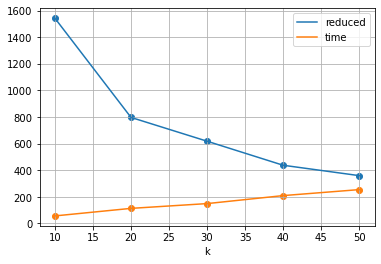

In [132]:
from matplotlib import pyplot as plt

plt.plot(res['k'], res['reduced'])
plt.scatter(res['k'], res['reduced'])
plt.plot(res['k'], res['time'])
plt.scatter(res['k'], res['time'])
plt.xlabel('k')
plt.legend(['reduced', 'time'])
plt.grid()
plt.show()

Можно увидеть, что время растет практически линейно, однако даже 10 исполнителей обрабатываются около минуты.

# Обучение модели

In [213]:
from sentence_transformers import SentenceTransformer, util
distil_multi_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

from gensim.models import Word2Vec
w2v_artists = Word2Vec.load("word2vec.model")

from scipy.spatial.distance import cosine, euclidean
similarity = [cosine, euclidean]

tracks = pd.read_csv('tracks.csv').set_index('Unnamed: 0')
data = pd.read_csv('ranking_data.csv').set_index('Unnamed: 0')

В качестве модели я буду использовать модель ранжирования. Обучение буду проводить на одном кусочке данных, разделенном на обучающую и валидационную выборки для отслеживания процесса. Дальнейшие рекомендации будут сделаны для случайных плейлистов с отбором кандидатов среди треков 10 наиболее близких исполнителей к среднему word2vec плейлиста.

In [207]:
def top_artists_df(vec, data, artist_model, top):
    artists = np.array(artist_model.wv.most_similar(np.array(vec), topn=top))[:, :1]
    artists = np.resize(artists, artists.shape[0]).tolist()
    df = data[data['artist_name'].apply(lambda x: x in artists)]
    
    return df

def transform_data(df, sentence_model, artist_model):
    d = df.copy()
    d['track_name'] = d['track_name'].apply(sentence_model.encode)
    d['album_name'] = d['album_name'].apply(sentence_model.encode)
    d['artist_name'] = d['artist_name'].apply(lambda x: artist_model.wv[x])
    
    return d

def data_ranking_pipline(playlist, data, sentence_model, artist_model, weight, similarity, top):
    playlist_info = playlist_made_part_pipline(playlist, sentence_model, artist_model, weight)
    df = top_artists_df(playlist_info['average_artist'], data, artist_model, top)
    df = transform_data(df, sentence_model, artist_model)
    
    for col, info in playlist_info.items():
        df[col] = [info] * df.shape[0]
        
    df['max_duration_diff'] = df['max_duration'] - df['duration_ms']
    df['min_duration_diff'] = df['min_duration'] - df['duration_ms']
    df['mean_duration_diff'] = df['mean_duration'] - df['duration_ms']
    
    for s in similarity:
        df['name_track_' + s.__name__] = df[['name', 'track_name']].apply(tuple, axis=1).apply(lambda x: s(x[0], x[1]))
        df['name_album_' + s.__name__] = df[['name', 'album_name']].apply(tuple, axis=1).apply(lambda x: s(x[0], x[1]))
        df['tracks_' + s.__name__] = df[['average_name', 'track_name']].apply(tuple, axis=1).apply(lambda x: s(x[0], x[1]))
        df['albums_' + s.__name__] = df[['average_album', 'album_name']].apply(tuple, axis=1).apply(lambda x: s(x[0], x[1]))
        df['artists_' + s.__name__] = df[['average_artist', 'artist_name']].apply(tuple, axis=1).apply(lambda x: s(x[0], x[1]))
    
    return df.drop(['name', 'max_duration', 'min_duration', 
                    'mean_duration', 'average_name', 'average_album', 
                    'average_artist', 'artist_name', 'track_name', 
                    'album_name', 'duration_ms'], axis=1)

def make_ranking_playlists(playlists, data, sentence_model, artist_model, weight, similarity, top=10): 
    dfs = []
    
    for playlist in playlists:
        dfs.append(data_ranking_pipline(playlist, data, sentence_model, artist_model, weight, similarity, top))
        
    return pd.concat(dfs)

Так как в данных присуствует группировка по плейлистам, то разделение на обучающую и валидационную выборки будут производиться именно на множестве id плейлистов, чтобыоценивать качество ранжирования непосредственно на плейлистах.

In [257]:
from sklearn.model_selection import train_test_split

pids = data['pid'].unique()
nums = np.arange(len(pids))
pids_train, pids_val, _, _ = train_test_split(pids, nums, test_size=0.33, random_state=42)

In [258]:
len(pids_train)

669

Формирую выборки, целевые признаки и группировки по плейлистам:

In [259]:
def make_train_test(data, pids_train, pids_test):        
    X_train = data[data['pid'].apply(lambda x: x in pids_train)]
    X_test = data[data['pid'].apply(lambda x: x in pids_test)]
    
    return X_train, X_test

In [260]:
X_train, X_val = make_train_test(data, pids_train, pids_val)

In [261]:
def X_y_pid(data):
    X = data.drop(['pid', 'pos'], axis=1)
    y = - 1 / data[['pos']]
    pid = data[['pid']]
    
    return X, y, pid

In [262]:
X_train, y_train, pid_train = X_y_pid(X_train)
X_val, y_val, pid_val = X_y_pid(X_val)

In [263]:
from catboost import CatBoostRanker, Pool

cat_boost_model = CatBoostRanker(loss_function='StochasticRank:metric=NDCG',
                                 custom_metric=['NDCG', 'AverageGain:top=10', 'QueryAUC'],
                                 random_seed=42)

train = Pool(data=X_train, label=y_train, group_id=pid_train)
val = Pool(data=X_val, label=y_val, group_id=pid_val)

In [264]:
cat_boost_model.fit(train, eval_set=val, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Теперь обучусь на всех данных:

In [302]:
X_, y_, pid_ = X_y_pid(data)
data_ = Pool(data=X_, label=y_, group_id=pid_)

In [305]:
cat_boost_model.fit(data_, verbose=False, plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [306]:
with open('catboostRanker_model.pkl','wb') as f:
    pickle.dump(cat_boost_model, f)

In [265]:
number = random.randint(1, 1000)
mpd_slice = read_slice(path, 'data/mpd.slice.' + str(number * 1000 - 1000) + "-" + str(number * 1000 - 1) + '.json')
mpd_slice['info']

{'generated_on': '2017-12-03 08:41:42.057563',
 'slice': '95000-95999',
 'version': 'v1'}

In [266]:
playlists = transform_mpd_slice_playlists_for_ranking(mpd_slice)['playlists']

In [307]:
%%time
df = make_ranking_playlists(playlists[:2], tracks, distil_multi_model, w2v_artists, weight_1, similarity)

Wall time: 1min 35s


In [308]:
df.shape

(2239, 14)

In [309]:
X, pid = df.drop(['pid'], axis=1), df[['pid']]

In [310]:
test = Pool(data=X, group_id=pid)

In [311]:
preds = cat_boost_model.predict(test)

In [312]:
df['rels'] = preds

In [313]:
df = df.sort_values(by=['pid', 'rels'], ascending=False)[['pid', 'rels']].merge(tracks, left_index=True, right_index=True,
                                                                               how='left')

In [314]:
df['pid'].unique()

array([95001, 95000], dtype=int64)

Можно видеть, что для первого плейлиста были рекомендованы несколько исполнителей, которые присутствуют в оригинальном продолжении плейлиста, однако с именованиями треков происходят ошибки.

In [315]:
df[df['pid'] == 95000].head(20)

,pid,rels,track_name,artist_name,album_name,duration_ms
Unnamed: 0,,,,,,
spotify:track:4pQbRjgavQZPc00lUr20Q2,95000,0.007479,Why You'd Want to Live Here,Death Cab for Cutie,The Photo Album,284773
spotify:track:4RBjWnCGcCO1aJfl5ooqnj,95000,0.006882,How To Live - Live from Spotify Sweden,Band of Horses,Spotify Sessions,232546
spotify:track:5MYfpFJYm8WNFGssR6H2Oz,95000,0.006814,No One's Gonna Love You - Live from Spotify Sw...,Band of Horses,Spotify Sessions,239080
spotify:track:2F950w5JasEsPPHfspO5yn,95000,0.006754,Know Your Onion - Spotify Sessions Curated by ...,The Shins,Spotify Sessions,152653
spotify:track:0H2NnpgV4iSiF8HMLh0qNw,95000,0.006428,Album Credits [As Read by Mike West],Death Cab for Cutie,Narrow Stairs,171650
spotify:track:01i8MZrj2g3sBCSANII4DF,95000,0.006371,You Can Do Better Than Me,Death Cab for Cutie,Narrow Stairs,119413
spotify:track:6srpczSEgGgBEsYsxD8oDR,95000,0.006357,The Shrine / An Argument,Fleet Foxes,Helplessness Blues,487293
spotify:track:1sJFz30QFvmSCIoHyKjw1k,95000,0.006343,Name For You - Recorded at Spotify Studios NYC,The Shins,Spotify Singles,191160
spotify:track:3JT4GS4MAMk4lC7SCeQ4SB,95000,0.006263,"Flightless Bird, American Mouth - Wedding Vers...",Iron & Wine,The Twilight Saga: Breaking Dawn - Part 1,24720


In [296]:
playlists[0]['recomend_part']

[{'pos': 65,
  'artist_name': 'Iron & Wine',
  'track_uri': 'spotify:track:0YjfKRYhN54qoTHicADSdL',
  'artist_uri': 'spotify:artist:4M5nCE77Qaxayuhp3fVn4V',
  'track_name': 'Grass Widows',
  'album_uri': 'spotify:album:3oPGyYlIVrG66eLKD93BN4',
  'duration_ms': 173000,
  'album_name': 'Ghost On Ghost'},
 {'pos': 66,
  'artist_name': 'Iron & Wine',
  'track_uri': 'spotify:track:7iWCvNuPvnxdhfH5gU0tIG',
  'artist_uri': 'spotify:artist:4M5nCE77Qaxayuhp3fVn4V',
  'track_name': 'Singers and the Endless Song',
  'album_uri': 'spotify:album:3oPGyYlIVrG66eLKD93BN4',
  'duration_ms': 218693,
  'album_name': 'Ghost On Ghost'},
 {'pos': 67,
  'artist_name': 'Iron & Wine',
  'track_uri': 'spotify:track:56o2b8Z2I7mR1jeCHYIN7S',
  'artist_uri': 'spotify:artist:4M5nCE77Qaxayuhp3fVn4V',
  'track_name': 'Sundown [Back in the Briars]',
  'album_uri': 'spotify:album:3oPGyYlIVrG66eLKD93BN4',
  'duration_ms': 138093,
  'album_name': 'Ghost On Ghost'},
 {'pos': 68,
  'artist_name': 'Iron & Wine',
  'track_ur

Для второго плейлиста также существуют пересечения, однако здесь присутствуют преимущественно несколько исполнителей, в то время как в оригинале исполнители более разнообразны, однако музыка, создаваемая данными исполнителями достаточно близка жанрово.

In [316]:
df[df['pid'] == 95001].head(20)

,pid,rels,track_name,artist_name,album_name,duration_ms
Unnamed: 0,,,,,,
spotify:track:41gjI27Qe5vzMHrLI7PpSS,95001,0.009918,Safe Sex Pay Checks,Rae Sremmurd,SremmLife,296040
spotify:track:6hcBxnLCwSePbZcUjd59WL,95001,0.009154,About Blood On the Money - Commentary,Future,DS2 - Track by Track Commentary,94719
spotify:track:7hDc8b7IXETo14hHIHdnhd,95001,0.008531,Passionfruit,Drake,More Life,298940
spotify:track:2Na0z2gfN67Rzf0vp74Wi3,95001,0.008194,Lose You,Drake,More Life,305373
spotify:track:0xl1w2q4VLojeXp4JfazPL,95001,0.007968,Sacrifices,Drake,More Life,307593
spotify:track:1UTdrjTrmIDKLADpcWnOWa,95001,0.007877,YNO,Rae Sremmurd,SremmLife,324933
spotify:track:6MbH1QiphMCPTqVEVC7UYi,95001,0.007375,Nothings Into Somethings,Drake,More Life,153724
spotify:track:5wihevBA7MO9PNYyWyTfkh,95001,0.007207,Brown Paper Bag,Migos,Culture,211244
spotify:track:0osPUefhvYxoB2eZw6prBt,95001,0.007116,One Man Can Change The World,Big Sean,Dark Sky Paradise,254626


In [317]:
playlists[1]['recomend_part']

[{'pos': 23,
  'artist_name': 'Travis Scott',
  'track_uri': 'spotify:track:1yxgsra98r3qAtxqiGZPiX',
  'artist_uri': 'spotify:artist:0Y5tJX1MQlPlqiwlOH1tJY',
  'track_name': 'Butterfly Effect',
  'album_uri': 'spotify:album:4fOw7xSDwqb58Z2Qia5j81',
  'duration_ms': 190677,
  'album_name': 'Butterfly Effect'},
 {'pos': 24,
  'artist_name': 'A Boogie Wit da Hoodie',
  'track_uri': 'spotify:track:1f5cbQtDrykjarZVrShaDI',
  'artist_uri': 'spotify:artist:31W5EY0aAly4Qieq6OFu6I',
  'track_name': 'Drowning (feat. Kodak Black)',
  'album_uri': 'spotify:album:3HHp5I6Q6SEyU5bkvoCtnV',
  'duration_ms': 209269,
  'album_name': 'The Bigger Artist'},
 {'pos': 25,
  'artist_name': 'Lil Yachty',
  'track_uri': 'spotify:track:40yJGQyEaBbIkXpwMFkXip',
  'artist_uri': 'spotify:artist:6icQOAFXDZKsumw3YXyusw',
  'track_name': 'One Night',
  'album_uri': 'spotify:album:4bJqW1SBOvsfcEzZwsjdjx',
  'duration_ms': 243269,
  'album_name': 'Lil Boat'},
 {'pos': 26,
  'artist_name': 'Rae Sremmurd',
  'track_uri': 

Отдельно стоит отметить, что дисперсия по показателям, связанным с исполнителем, в тестовых данных очень мала, так как выбирались только 10 ближайших исполнителей с целью сокращения времени обработки. Отсюда следует и неразнообразность исполнителей в рекомендациях.